<a href="https://colab.research.google.com/github/anishjohnson/NYC_Taxi_TripTime_Prediction/blob/main/NYC_Taxi_TripDuration_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Taxi trip time Prediction : Predicting total ride duration of taxi trips in New York City</u></b>

## <b> Problem Description </b>

### Your task is to build a model that predicts the total ride duration of taxi trips in New York City. Your primary dataset is one released by the NYC Taxi and Limousine Commission, which includes pickup time, geo-coordinates, number of passengers, and several other variables.

## <b> Data Description </b>

### The dataset is based on the 2016 NYC Yellow Cab trip record data made available in Big Query on Google Cloud Platform. The data was originally published by the NYC Taxi and Limousine Commission (TLC). The data was sampled and cleaned for the purposes of this project. Based on individual trip attributes, you should predict the duration of each trip in the test set.

### <b>NYC Taxi Data.csv</b> - the training set (contains 1458644 trip records)


### **Data fields**
* id - a unique identifier for each trip
* vendor_id - a code indicating the provider associated with the trip record
* pickup_datetime - date and time when the meter was engaged
* dropoff_datetime - date and time when the meter was disengaged
* passenger_count - the number of passengers in the vehicle (driver entered value)
* pickup_longitude - the longitude where the meter was engaged
* pickup_latitude - the latitude where the meter was engaged
* dropoff_longitude - the longitude where the meter was disengaged
* dropoff_latitude - the latitude where the meter was disengaged
* store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
* trip_duration - duration of the trip in seconds

# **Import libraries and data.**

In [2]:
# import the libraries.
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import datetime as dt
# from scipy.stats import zscore

import warnings
warnings.filterwarnings("ignore")

# We will use haverseine to calculate the distance using the longitudinal and lattitue data.
!pip install haversine
from haversine import haversine

In [3]:
# Mount the drive.
from google.colab import drive
drive.mount('/content/drive/')

# Load the data.
df = pd.read_csv('/content/drive/MyDrive/Capstone data files/NYC Taxi Data.csv')

# Create a copy of data to be on the safer side.
nyc_df = df

Mounted at /content/drive/


# **Exploratory Data Analysis.**

In [4]:
nyc_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [5]:
nyc_df.tail()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,778
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,655
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,764
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,373
1458643,id1209952,1,2016-04-05 14:44:25,2016-04-05 14:47:43,1,-73.979538,40.781750,-73.972809,40.790585,N,198


In [6]:
# Check the shape of our data.
shape = nyc_df.shape
print(f'The dataset contains {shape[0]} rows and {shape[1]} columns.')

The dataset contains 1458644 rows and 11 columns.


In [7]:
# Check if it contains null values.
nyc_df.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

In [8]:
# Only originals needed, remove the duplicates.
duplicates = nyc_df.duplicated().sum()

if duplicates == 0:
  print('No duplicates exist we are good to go.👌')
else:
  print(duplicates,'exist remove them.')

No duplicates exist we are good to go.👌


In [9]:
# Reveal information about the data.
nyc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [10]:
# Get some statiscis.
nyc_df.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


***Points to be noted:***
* *id can be dropped - as every ride would have different id it would'nt give any useful insight.*
* *pickup_datetime and dropoff_time need to be changed to datetime format - currently they are in string (object) format.*
* *extract data from datetime values.*
* *duration is given in seconds lets convert it into minutes.*
* *store_and_fwd_flag is a categorical variable that needs to be converted.*
* *vendor_id consists of two values 1 and 2.*
* *passenger_count ranges from 0-9, the difference between the 75th percentile and the max value shows the precense of outliers.*
* *trip_duration_minutes also contains outliers.*

In [11]:
# Drop id.
nyc_df.drop('id', inplace=True, axis=1)

In [12]:
# Change format for pickup_datetime and dropoff_time.
nyc_df['pickup_datetime'] = pd.to_datetime(nyc_df['pickup_datetime'])
nyc_df['dropoff_datetime'] = pd.to_datetime(nyc_df['dropoff_datetime'])

In [13]:
# Retrive day and month data.
nyc_df['day'] = nyc_df.pickup_datetime.dt.weekday
nyc_df['month'] = nyc_df.pickup_datetime.dt.month

# Retrive pickup and dropoff hrs.
nyc_df['pickup_hour'] = nyc_df.pickup_datetime.dt.hour
nyc_df['dropoff_hour'] = nyc_df.dropoff_datetime.dt.hour

In [14]:
# Now lets drop pickup_datetime and dropoff_datetime as we have extracted data from it.
nyc_df.drop(['pickup_datetime', 'dropoff_datetime'], inplace=True, axis=1)

In [15]:
# Convert the data from seconds to mins.
nyc_df['trip_duration_minutes']=nyc_df['trip_duration']/60

# Drop duration in seconds.
nyc_df.drop('trip_duration', inplace=True, axis=1)

In [16]:
# Recheck if formats been changed.
nyc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 12 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   vendor_id              1458644 non-null  int64  
 1   passenger_count        1458644 non-null  int64  
 2   pickup_longitude       1458644 non-null  float64
 3   pickup_latitude        1458644 non-null  float64
 4   dropoff_longitude      1458644 non-null  float64
 5   dropoff_latitude       1458644 non-null  float64
 6   store_and_fwd_flag     1458644 non-null  object 
 7   day                    1458644 non-null  int64  
 8   month                  1458644 non-null  int64  
 9   pickup_hour            1458644 non-null  int64  
 10  dropoff_hour           1458644 non-null  int64  
 11  trip_duration_minutes  1458644 non-null  float64
dtypes: float64(5), int64(6), object(1)
memory usage: 133.5+ MB


***Now lets bring in the charts and diagrams for better understanding.***  *😊*

## **Dependent Variable.**

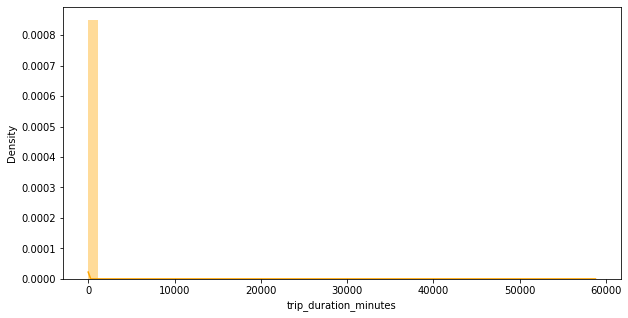

In [17]:
# Check out the trip_duration.
plt.figure(figsize=(10,5))
sns.distplot(nyc_df['trip_duration_minutes'], color='orange')
plt.show()

***trip_duration_minutes is positively skewed, apply log transformation to solve it.***

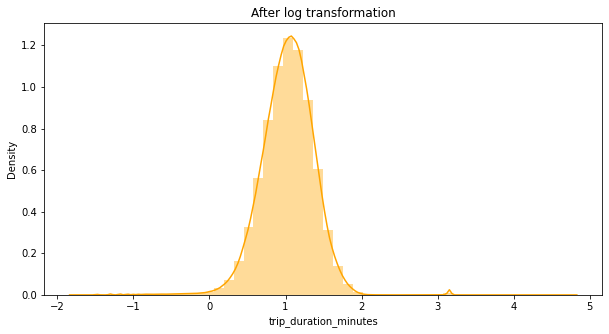

In [18]:
# Apply log transformation and plot it.
plt.figure(figsize=(10,5))
plt.title('After log transformation')
sns.distplot(np.log10(nyc_df['trip_duration_minutes']), color='orange')
plt.show()

***log transformation has solved the problem of skewness, but there are some values which are zero and since we need to predict the trip_duration the zeros will have to go, we will look about it more in feature engineering part.***

## **Independent Variables.**

In [19]:
nyc_df.head(1)

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,day,month,pickup_hour,dropoff_hour,trip_duration_minutes
0,2,1,-73.982155,40.767937,-73.96463,40.765602,N,0,3,17,17,7.583333


In [20]:
independent_variables = ['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
                         'dropoff_latitude', 'store_and_fwd_flag', 'day', 'month', 'pickup_hour', 'dropoff_hour']

**vendor_id.**

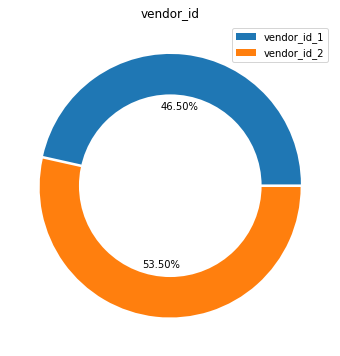

In [21]:
# Calculate the trips done by each vendor.
one = len(nyc_df[nyc_df['vendor_id'] == 1])
two = len(nyc_df[nyc_df['vendor_id'] == 2])
v_id = [one, two]
v_name = ['vendor_id_1', 'vendor_id_2']

# Plot it.
fig = plt.figure(figsize=(6,6))
plt.pie(v_id, autopct='%1.2f%%', explode=(0.01,0.01))
plt.title('vendor_id')
plt.legend(labels=v_name)

#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.show()

***53.50% of the trips are completed by the vendor 2 and 46.50% of the trips are completed by vendor 1.***

.

**passenger_count.**

In [22]:
nyc_df['passenger_count'].describe()

count    1.458644e+06
mean     1.664530e+00
std      1.314242e+00
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      9.000000e+00
Name: passenger_count, dtype: float64

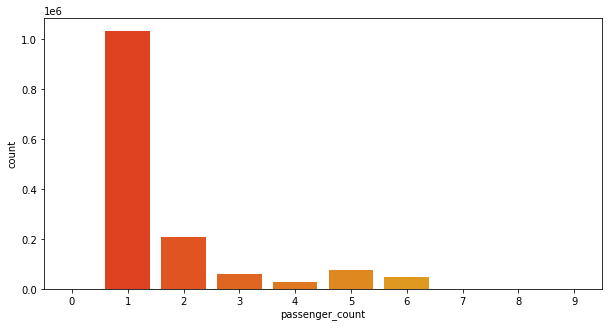

In [23]:
# Passenger count.
plt.figure(figsize=(10,5))
sns.countplot(nyc_df['passenger_count'], palette='autumn')
plt.show()

* ***some values are zero which mean either the trip was cancled or there was an error in the data entry.***
* ***7, 8, 9 are extreme cases considering the capacity of a car, so we will get rid of them.***
* ***most of the trips (75%) contain atmost 1 or 2 passengers.***

.

**pickup/dropoff latitude and longitude.**

.

**store_and_fwd_flag.**

In [57]:
nyc_df['store_and_fwd_flag'].describe()

count     1458644
unique          2
top             N
freq      1450599
Name: store_and_fwd_flag, dtype: object

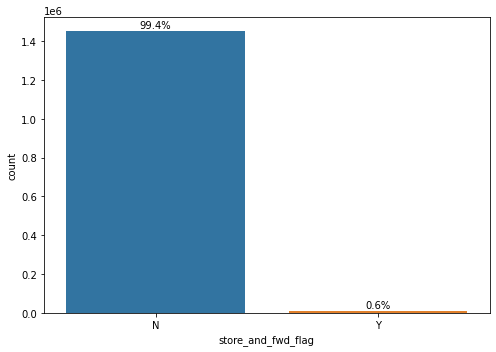

In [67]:
# Plot it.
plt.figure(figsize=(7,5))
ax = sns.countplot(nyc_df['store_and_fwd_flag'])

total = len(nyc_df)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='center')
plt.tight_layout()
plt.show()

* ***99.4% of the data values are N and only 0.6% 0f values are Y, which means most of the data was uploaded directly without storing it and forwarding.***
* ***this ia a categorical feature which we will be converting into numeric by getting dummies.***